In [1]:
import glob
import re

import scipy.interpolate as interpolate
from matplotlib import pyplot as plt
import numpy as np

from utils import Graph

# Different pressure levels
P_v = [2]#, 7, 15]
N_v = [1.15e19]#, 4.02e19, 8.61e19]
colors = ['C0']#, 'C1', 'C2']
colors_th = ['C0--']#, 'C1--', 'C3--']

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

In [2]:
PATH = '/home/david/data/SimLArCADe/gar-data/2PSI/'

The below imports and processes the simulation runs. At each bulk field, $20$ simulations were run for $1$ $\mu$s at the three investigated pressures.

In [3]:
E_vals = [[], [], []]

v_vals = [[], [], []]
v_devs = [[], [], []]

eV_vals = [[], [], []]
eV_devs = [[], [], []]

for i, p in enumerate(P_v):
    file_tree = {}

    for file in glob.glob(f'{PATH}/*/*.txt'):
        key = int(re.search(r'(\d*)(?:V)', file).group(1))
        if (key in file_tree):
            file_tree[key].append(file)
        else:
            file_tree[key] = [file]

    for key, value in sorted(file_tree.items()):
        group = Graph(value)

        E_vals[i].append(key)

        v_vals[i].append(group.drift_mean())
        v_devs[i].append(group.drift_std_dev())

        eV_vals[i].append(np.mean([np.mean(k) for k in group.ke]))
        eV_devs[i].append(np.std([np.mean(k) for k in group.ke], ddof=1))

The below cells plots mean electron energy across different pressures. As the $x$-axis is normalized with respect to pressure, all three plots should coincide. The data is taken from V. Puech and L. Torchin. Collision cross sections and electron swarm parameters in argon. Journal of Physics D: Applied Physics, 19(12):2309–2323, Dec 1986.

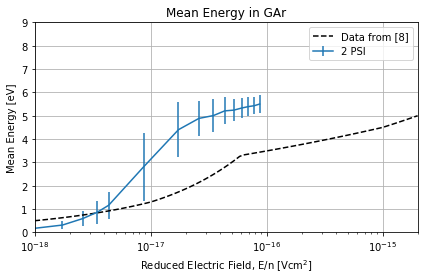

In [4]:
x = [1e-18, 1e-17, 6e-17, 1e-15, 2e-15]
y = [0.5, 1.3, 3.3, 4.5, 5]

data = log_interp1d(x, y)
x_vs = np.logspace(-18, np.log10(2e-15), 100)

# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

plt.plot(x_vs, data(x_vs), 'k--', label='Data from [8]')

for i, p in enumerate(P_v):
    plt.errorbar([E / N_v[i] for E in E_vals[i]], eV_vals[i], yerr=eV_devs[i], label=f'{p} PSI')

plt.xlabel('Reduced Electric Field, E/n [Vcm$^2$]')
plt.ylabel('Mean Energy [eV]')

plt.xscale('log')
plt.xlim(1e-18, 2e-15)
plt.ylim(0, 9)

plt.title(f'Mean Energy in GAr')

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# plt.savefig(f'gar_energy.pdf', bbox_inches='tight')

The below cells plots mean electron drift velocity across different pressures. As the $x$-axis is normalized with respect to pressure, all three plots should coincide. The data is taken from V. Puech and L. Torchin. Collision cross sections and electron swarm parameters in argon. Journal of Physics D: Applied Physics, 19(12):2309–2323, Dec 1986.

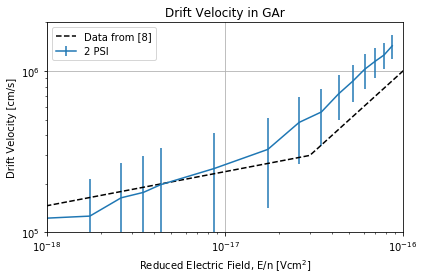

In [6]:
x = [1e-19, 3e-17, 2e-15]
y = [9e4, 3e5, 2e7]

data = log_interp1d(x, y)
x_vs = np.logspace(-19, np.log10(2e-15), 100)

# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

plt.plot(x_vs, data(x_vs), 'k--', label='Data from [8]')

for i, p in enumerate(P_v):
        plt.errorbar([E / N_v[i] for E in E_vals[i]], [v * 1e2 for v in v_vals[i]], yerr=[v * 1e2 for v in v_devs[i]], label=f'{p} PSI')

plt.xlabel('Reduced Electric Field, E/n [Vcm$^2$]')
plt.ylabel('Drift Velocity [cm/s]')
plt.title(f'Drift Velocity in GAr')

plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e-19, 1e-14)
#plt.ylim(1e4, 1e8)

plt.xlim(1e-18, 1e-16)
plt.ylim(1e5, 2e6)


plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# plt.savefig(f'gar_drift.pdf', bbox_inches='tight')